# S07-demo-03 – Иерархическая кластеризация и дендрограмма

В этом демо мы разберём **иерархическую кластеризацию** (Agglomerative, bottom-up) и научимся **читать дендрограмму**.

## Что вы освоите
- что такое *linkage* (Ward / complete / average / single) и как он влияет на результат;
- почему для distance-based методов почти всегда нужно **масштабирование признаков**;
- как выбирать число кластеров через дендрограмму и/или внутренние метрики (например, silhouette);
- как быстро визуализировать кластеры в 2D через PCA (как *инструмент понимания*, не как “доказательство качества”).

## Как работать с ноутбуком
- запускайте ячейки по порядку;
- для дендрограммы нужен `scipy` (если импорты не прошли – установите и перезапустите ядро);
- при сравнении *linkage* смотрите, как меняются “ветви” и устойчивость разбиения.

## 0. Импорты и базовые настройки

Мы используем:
- `scikit-learn` для датасетов, scaling и `AgglomerativeClustering`;
- `scipy` для построения дендрограммы (`linkage`, `dendrogram`);
- `PCA` для 2D-визуализации кластеров.

Важно: фиксируем `RANDOM_STATE`, чтобы результаты (например, подвыборки) были воспроизводимыми.

In [1]:
# Если вы запускаете ноутбук в "чистом" окружении:
# pip install -U scikit-learn matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Дендрограмма рисуется через SciPy
try:
    from scipy.cluster.hierarchy import dendrogram, linkage
except Exception as e:
    dendrogram = None
    linkage = None
    print("⚠️ SciPy не импортировался. Для дендрограммы установите scipy: pip install scipy")
    print("Причина:", repr(e))

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1. Интуиция: что происходит в агломеративной кластеризации

Агломеративная кластеризация начинается с того, что **каждая точка – это отдельный кластер**. Дальше алгоритм многократно:
1) находит **два ближайших** кластера,
2) объединяет их,
3) пересчитывает расстояния до нового кластера,

пока не останется один большой кластер (или пока не достигнем нужного числа кластеров / порога расстояния).

Ключевой вопрос: **как измерять расстояние между кластерами?** Этим управляет *linkage*:
- **single**: расстояние = минимальная дистанция между точками (часто даёт “цепочки”);
- **complete**: расстояние = максимальная дистанция (стремится к компактности);
- **average**: средняя дистанция;
- **ward**: объединяем так, чтобы минимально увеличивалась внутрикластерная дисперсия (часто хорош для “шариков”).

Если признаки в разных шкалах, расстояния будут “перекошены”, поэтому обычно делаем **StandardScaler**.

In [2]:
def plot_pca_2d(X, labels, title):
    """Простая 2D-визуализация кластеров через PCA."""
    pca = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca.fit_transform(X)

    plt.figure(figsize=(7, 5))
    plt.scatter(X2[:, 0], X2[:, 1], c=labels, s=35)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True, alpha=0.25)
    plt.show()

def cluster_sizes(labels):
    """Размеры кластеров (сколько точек в каждом)."""
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


## 2. Датасет Iris: “реальные” табличные данные

Iris – небольшой классический набор данных: 150 объектов, 4 числовых признака.
Изначально он размечен по 3 видам ириса – но в unsupervised-сценарии **мы делаем вид, что меток нет**.

In [3]:
iris = load_iris()
X = iris.data
feature_names = iris.feature_names

print("X.shape:", X.shape)
print("Признаки:", feature_names)


X.shape: (150, 4)
Признаки: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### 2.1 Масштабирование признаков

Иерархическая кластеризация работает на расстояниях, поэтому приведём признаки к сопоставимой шкале.


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("После scaling: mean ~", X_scaled.mean(axis=0).round(3))
print("После scaling: std  ~", X_scaled.std(axis=0).round(3))


После scaling: mean ~ [-0. -0. -0. -0.]
После scaling: std  ~ [1. 1. 1. 1.]


## 3. Дендрограмма: как её строить и читать

Дендрограмма – “дерево” последовательных объединений кластеров.
- по оси X: объекты (или группы объектов);
- по оси Y: **расстояние объединения** (насколько “далеко” были объединяемые кластеры).

Чем выше происходит объединение, тем менее похожи были объединяемые кластеры.
По дендрограмме часто выбирают число кластеров: “режем” дерево горизонтальной линией.

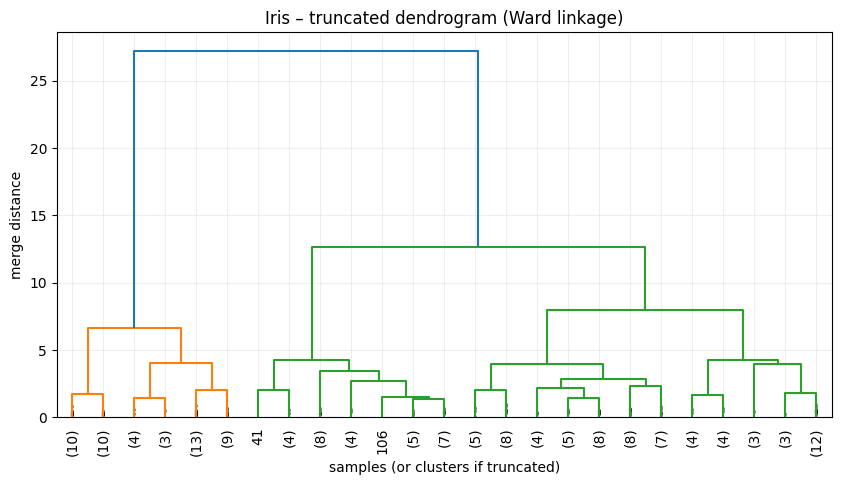

In [5]:
def plot_dendrogram(X_scaled, method="ward", truncate_mode=None, p=30, title=None):
    if linkage is None or dendrogram is None:
        print("SciPy недоступен – пропускаем дендрограмму.")
        return

    Z = linkage(X_scaled, method=method)
    plt.figure(figsize=(10, 5))
    dendrogram(
        Z,
        truncate_mode=truncate_mode,
        p=p,
        leaf_rotation=90,
        leaf_font_size=10,
        show_contracted=True
    )
    plt.title(title or f"Dendrogram (linkage='{method}')")
    plt.xlabel("samples (or clusters if truncated)")
    plt.ylabel("merge distance")
    plt.grid(True, alpha=0.2)
    plt.show()
    return Z

# Полная дендрограмма на 150 объектах будет слишком плотной,
# поэтому используем "truncated" вариант (показываем верхние уровни).
Z_ward = plot_dendrogram(
    X_scaled,
    method="ward",
    truncate_mode="lastp",
    p=25,
    title="Iris – truncated dendrogram (Ward linkage)"
)


### 3.1 Как *linkage* меняет дендрограмму

Сравним разные варианты на **подвыборке** (чтобы дендрограмма читалась).


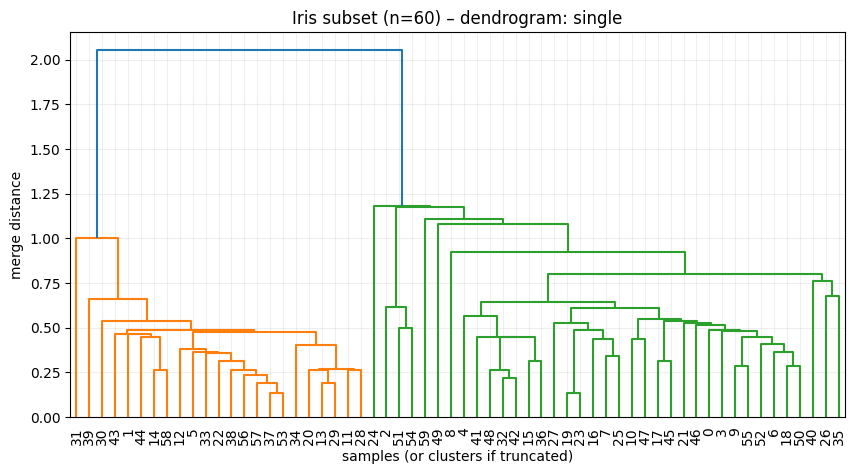

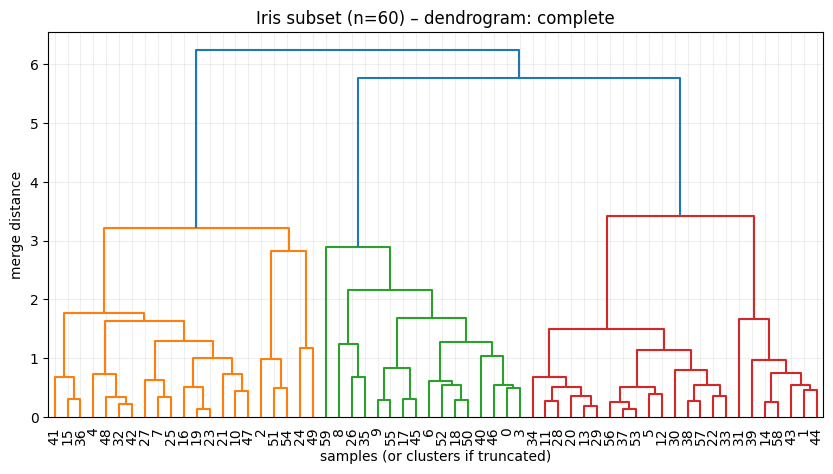

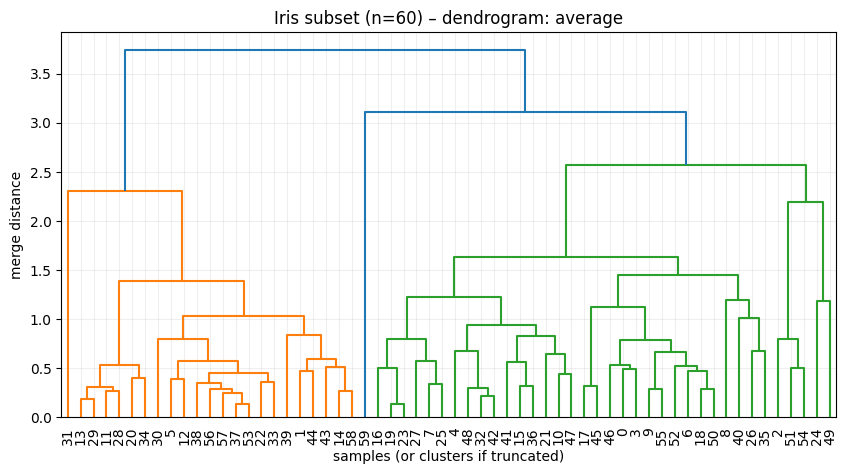

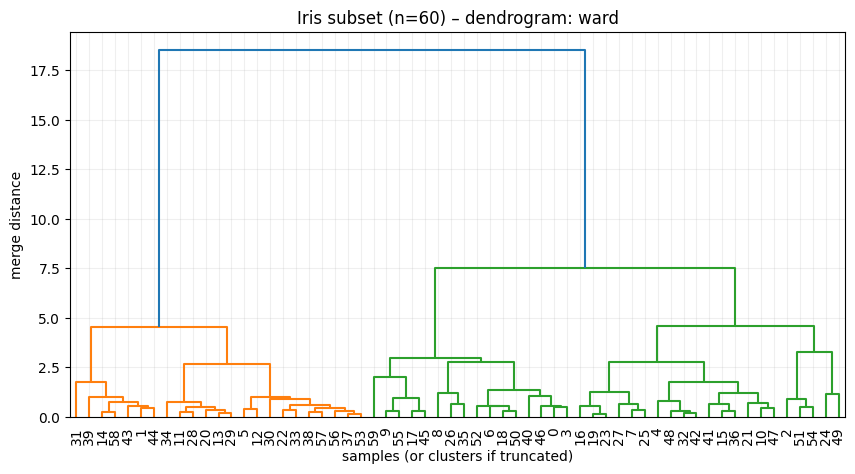

In [6]:
subset_idx = np.random.choice(len(X_scaled), size=60, replace=False)
X_sub = X_scaled[subset_idx]

for method in ["single", "complete", "average", "ward"]:
    _ = plot_dendrogram(
        X_sub,
        method=method,
        truncate_mode=None,
        p=30,
        title=f"Iris subset (n=60) – dendrogram: {method}"
    )


## 4. Практика: выбираем число кластеров

Есть два типичных подхода:
1) **по дендрограмме**: ищем “большие скачки” по высоте (между объединениями) и режем там;
2) **по внутренним метрикам**: например, silhouette (чем выше – тем лучше, но это не абсолютная истина).

Ниже – silhouette для разных `k`.

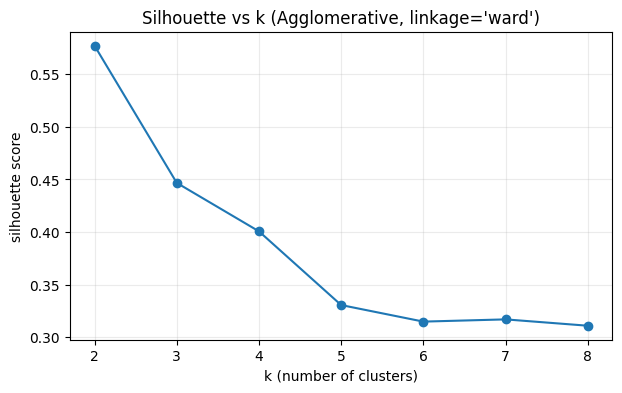

Best k by silhouette: 2 (score=0.577)


In [7]:
def silhouette_over_k(X_scaled, linkage_name="ward", k_min=2, k_max=10):
    ks = []
    scores = []

    for k in range(k_min, k_max + 1):
        model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
        labels = model.fit_predict(X_scaled)

        # silhouette требует минимум 2 кластера и чтобы не было "всё в один"
        score = silhouette_score(X_scaled, labels)
        ks.append(k)
        scores.append(score)

    plt.figure(figsize=(7, 4))
    plt.plot(ks, scores, marker="o")
    plt.title(f"Silhouette vs k (Agglomerative, linkage='{linkage_name}')")
    plt.xlabel("k (number of clusters)")
    plt.ylabel("silhouette score")
    plt.grid(True, alpha=0.25)
    plt.show()

    best_k = ks[int(np.argmax(scores))]
    best_score = float(np.max(scores))
    print(f"Best k by silhouette: {best_k} (score={best_score:.3f})")

silhouette_over_k(X_scaled, linkage_name="ward", k_min=2, k_max=8)


### 4.1 Обучаем модель с выбранным `k`

Для Iris почти всегда разумно начать с `k=3` (но мы это “не знаем” в unsupervised).  
Сейчас просто возьмём `k=3` и посмотрим на результат.


Cluster sizes: {0: 71, 1: 49, 2: 30}


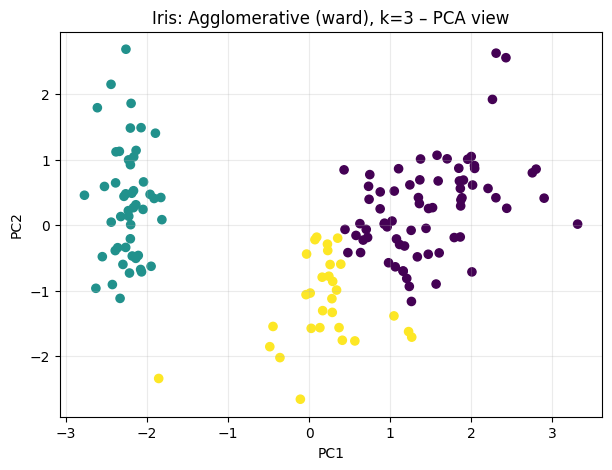

In [8]:
k = 3
model = AgglomerativeClustering(n_clusters=k, linkage="ward")
labels = model.fit_predict(X_scaled)

print("Cluster sizes:", cluster_sizes(labels))
plot_pca_2d(X_scaled, labels, f"Iris: Agglomerative (ward), k={k} – PCA view")


## 5. Второй пример: синтетика (`make_blobs`)

Здесь кластеры заведомо “шарообразные” – это удобный сценарий для *Ward linkage*.

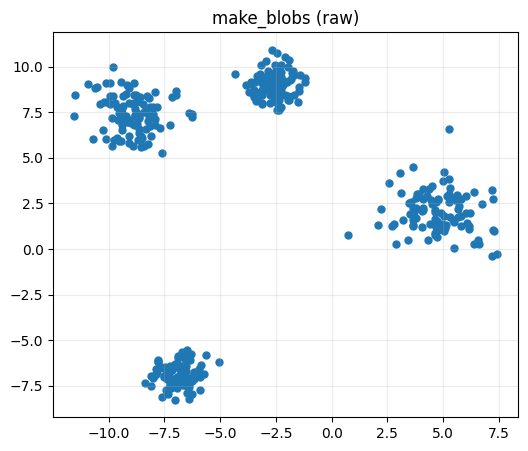

In [9]:
Xb, _ = make_blobs(
    n_samples=400,
    centers=4,
    n_features=2,
    cluster_std=[0.7, 1.2, 0.6, 1.0],
    random_state=RANDOM_STATE
)

# В 2D можно сразу посмотреть глазами
plt.figure(figsize=(6, 5))
plt.scatter(Xb[:, 0], Xb[:, 1], s=25)
plt.title("make_blobs (raw)")
plt.grid(True, alpha=0.25)
plt.show()

Xb_scaled = StandardScaler().fit_transform(Xb)


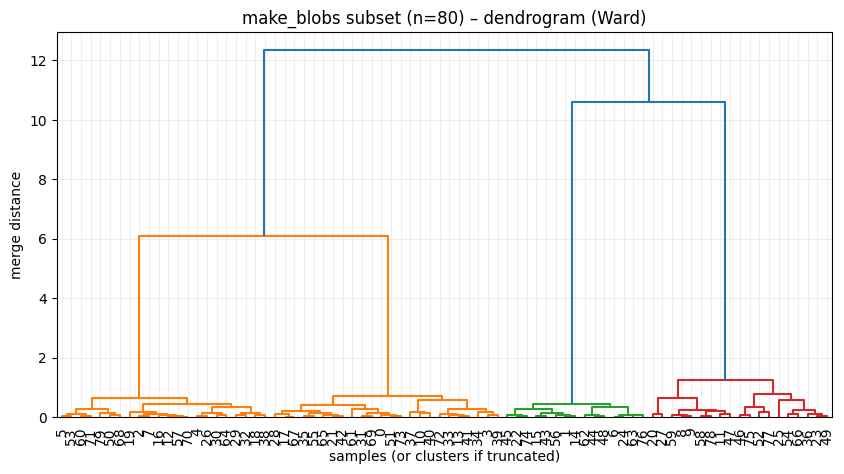

In [10]:
# На 2D-данных можно показать "полную" дендрограмму, но 400 объектов всё равно тяжело.
# Сделаем denrogram по подвыборке.
subset_idx = np.random.choice(len(Xb_scaled), size=80, replace=False)
_ = plot_dendrogram(
    Xb_scaled[subset_idx],
    method="ward",
    truncate_mode=None,
    p=30,
    title="make_blobs subset (n=80) – dendrogram (Ward)"
)


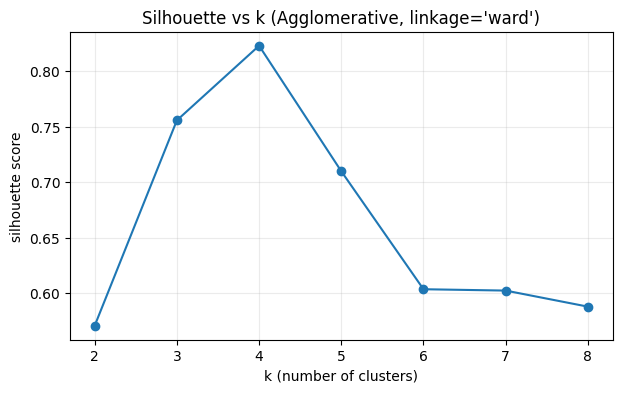

Best k by silhouette: 4 (score=0.823)
Cluster sizes: {0: 100, 1: 100, 2: 100, 3: 100}


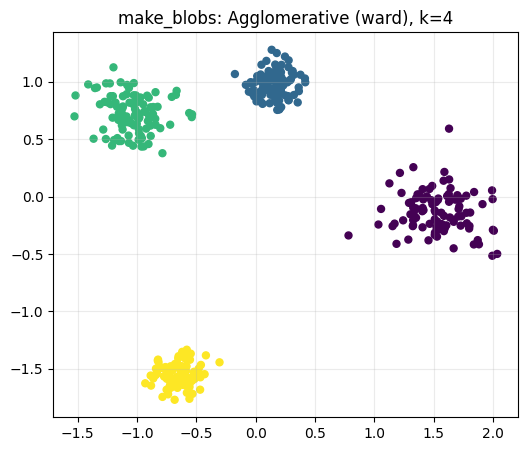

In [11]:
# Подбор k по silhouette
silhouette_over_k(Xb_scaled, linkage_name="ward", k_min=2, k_max=8)

# Возьмём k=4 (ожидаемо для blobs)
k = 4
model_b = AgglomerativeClustering(n_clusters=k, linkage="ward")
labels_b = model_b.fit_predict(Xb_scaled)

print("Cluster sizes:", cluster_sizes(labels_b))
plt.figure(figsize=(6, 5))
plt.scatter(Xb_scaled[:, 0], Xb_scaled[:, 1], c=labels_b, s=25)
plt.title(f"make_blobs: Agglomerative (ward), k={k}")
plt.grid(True, alpha=0.25)
plt.show()


## Выводы (коротко)

- Иерархическая кластеризация “строит дерево” объединений; дендрограмма – визуализация этого дерева.
- *Linkage* – ключевой выбор: он определяет, что значит “кластеры близки”.
- Масштабирование признаков обычно критично.
- Внутренние метрики (например, silhouette) помогают сравнивать варианты, но их важно интерпретировать вместе с визуализацией и здравым смыслом.